In [1]:
import numpy as np
import pickle as pkl
import torch
import umap
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.tableau import Tableau_20 as pallette

from WaveletVAE.experiments.configs.demo_config import get_demo_config
from SignalTransformData.data_modules.simulated import SinusoidalDataModule

sns.set()
sns.set_palette(pallette.mpl_colors)

# sns.set_palette(ListedColormap(palette.mpl_colormap))
# style.use('seaborn')


# Replicate data

In [2]:
config = get_demo_config()
classes = len(config["bias"])
channels = len(config["bias"][0])
length = 512
print(f"{classes} classes, with {channels} channels")

dm = SinusoidalDataModule(config, samples=2000, batch_size=128, sig_length=length)

lbl, lbl_idx = np.unique(dm.labels, return_index=True)
X = dm.signals_no_noise[lbl_idx, :].reshape((6, -1))

6 classes, with 2 channels


# Make data dataframe

In [3]:
data = []

# Class 1 and 2
# No distinction in resolution sources
for res in ["Low-resolution", "Mid-resolution", "High-resolution"]:
    for cls in [0, 1]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])

# Class 3 and 4
# Distinction at middle resolution
for res in ["Low-resolution"]:
    for cls in [2, 3]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[2, i]])
for res in ["Mid-resolution", "High-resolution"]:
    for cls in [2, 3]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])
            
# Class 5 and 6
# Distinction at high resolution
for res in ["Low-resolution", "Mid-resolution"]:
    for cls in [4, 5]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[4, i]])
for res in ["High-resolution"]:
    for cls in [4, 5]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])

In [4]:
df = pd.DataFrame(data, columns=["loci", "resolution", "class", "signal"])
df.head()

,loci,resolution,class,signal
0,0,Low-resolution,1,0.000000
1,1,Low-resolution,1,-0.000009
2,2,Low-resolution,1,-0.000038
3,3,Low-resolution,1,-0.000085
4,4,Low-resolution,1,-0.000151


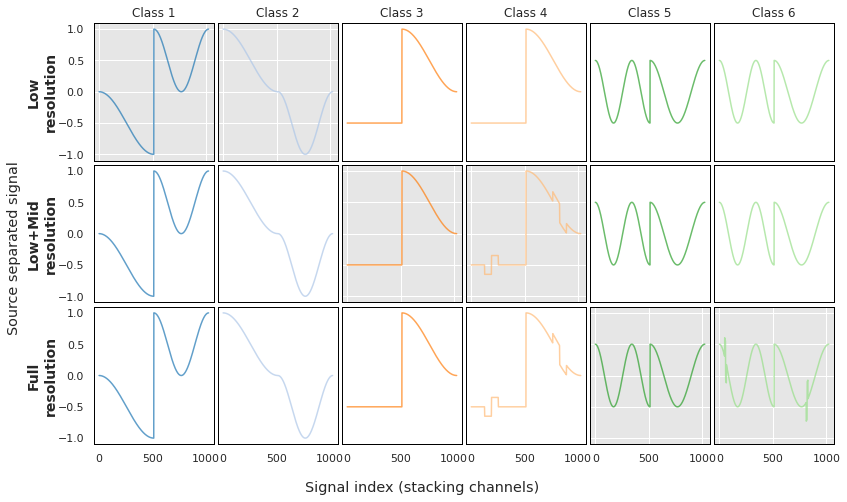

In [5]:
g = sns.FacetGrid(df, col="class", row="resolution", hue="class", margin_titles=True, despine=False, height=2.5, aspect=0.8)
g.map(sns.lineplot, "loci", "signal", alpha=.7)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="Class {col_name}", row_template="")    # {row_name}

for ax,l in zip(g.axes[:,0], ["Low\nresolution", "Low+Mid\nresolution", "Full\nresolution"]):
    ax.set_ylabel(l, fontweight='bold', fontsize=14, rotation=90)  #      ha='right', va='center'
    ax.yaxis.set_label_coords(-0.3, 0.5)

    
g.set_xlabels(label="", clear_inner=True, )
# g.set_ylabels(label="", clear_inner=True, )
g.fig.supxlabel("Signal index (stacking channels)")
g.fig.supylabel("Source separated signal")

for ax in g.axes.flatten():
    for _, spine in ax.spines.items():
        spine.set_visible(True) 
        spine.set_color('black')
        spine.set_linewidth(1)
        
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Low-resolution" and (col_val == 1 or col_val == 2):
        ax.set_facecolor(".9")
    elif row_val == "Mid-resolution" and (col_val == 3 or col_val == 4):
        ax.set_facecolor(".9")
    elif row_val == "High-resolution" and (col_val == 5 or col_val == 6):
        ax.set_facecolor(".9")
    else:
        ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
plt.gcf().set_size_inches(12, 7)
plt.savefig("toy1.png", dpi=500, format='png')

# Visualise Wave-LSTM model output

In [6]:
with open("output-hpc-demo-ae.pkl", 'rb') as file:
    meta_results = pkl.load(file)

J = len(meta_results["hidden"])
lbls = meta_results["labels"].cpu().numpy()

## UMAP of the scale embeddings, predicted filter bank, and masked inputs

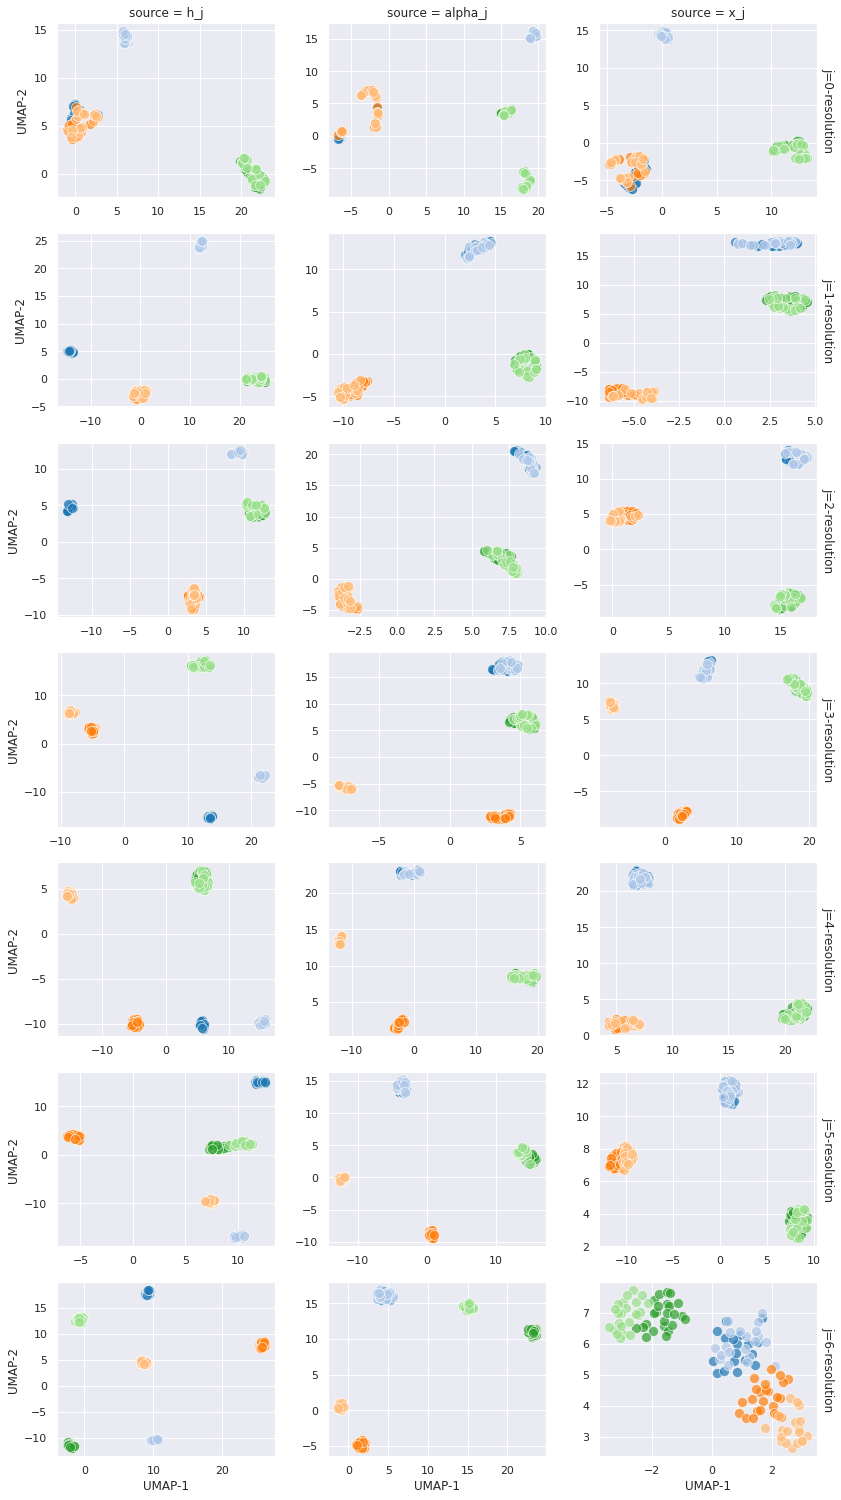

In [7]:
data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j}-resolution" for j in range(J)]): 

    h_j = meta_results["hidden"][j_res].cpu().numpy()
    alpha_j = meta_results["filter_bank"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # UMAP of scale embeddings, alpha_j prediction, and masked input
    for val, val_name in zip([h_j, alpha_j, x_j], ["h_j", "alpha_j", "x_j"]):
    
        reducer = umap.UMAP()
        scaled_val = StandardScaler().fit_transform(val.reshape((val.shape[0], -1)))
        embedding = reducer.fit_transform(scaled_val)

        for i in range(embedding.shape[0]):
            data.append([embedding[i, 0], embedding[i, 1], 
                         val_name,
                         j_name, lbls[i] + 1])    

df_emb = pd.DataFrame(data, columns=["UMAP-1", "UMAP-2", "source", "resolution", "class"])
df_emb.head()


# Plot
g = sns.FacetGrid(df_emb, row="resolution", col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")

## Visualise masked input

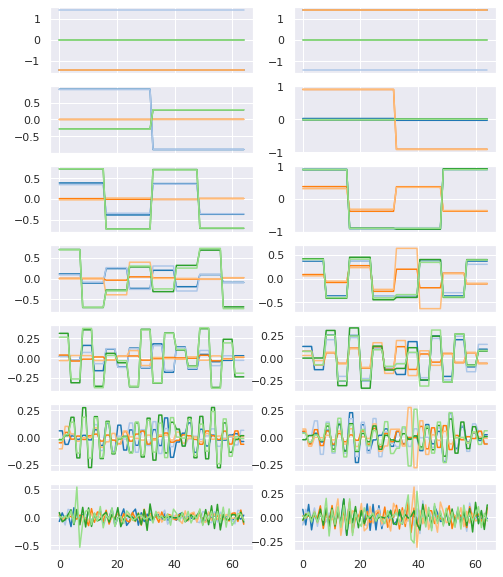

In [29]:
lbl_idx6 = np.unique(lbls, return_index=True)[1]

fig, axes = plt.subplots(nrows=J, ncols=2, figsize=(8,10), sharex=True)
for j_idx, (j_res, j_name) in enumerate(zip([i for i in range(J)], [f"{j}-resolution" for j in range(J)])): 
    x_j = meta_results["masked_inputs"][j_res]

    x_j_flat = torch.flatten(x_j, start_dim=2).cpu().numpy()
    t = np.linspace(0,x_j_flat.shape[2], x_j_flat.shape[2])
    
    y6_channels = x_j_flat[lbl_idx6, :, :]
    
    for i in range(y6_channels.shape[0]):
        axes[j_idx, 0].plot(t, y6_channels[i, 0, :])
        axes[j_idx, 1].plot(t, y6_channels[i, 1, :])

# Save for paper
for j_idx, (j_res, j_name) in enumerate(zip([i for i in range(J)], [f"{j}-resolution" for j in range(J)])): 
    x_j = meta_results["masked_inputs"][j_res]

    x_j_flat = torch.flatten(x_j, start_dim=2).cpu().numpy()
    t = np.linspace(0,x_j_flat.shape[2], x_j_flat.shape[2])
    
    y6_channels = x_j_flat[lbl_idx6, :, :]
    
    for c in range(2):
        fig, ax = plt.subplots()
        for i in range(y6_channels.shape[0]):
            ax.plot(t, y6_channels[i, c, :])
            ax.set_facecolor((0, 0, 0, 0))
            ax.set_xticks([])
            ax.set_yticks([])
            for _, spine in ax.spines.items():
                spine.set_visible(True)
                spine.set_color('black')
                spine.set_linewidth(1)
                
        plt.savefig(f"masked_input_res{j_res+1}_channel{c}.png", dpi=500, format='png', transparent=True)
        plt.tight_layout()
        plt.close()
    


## Plot selective resolution embeddings for paper

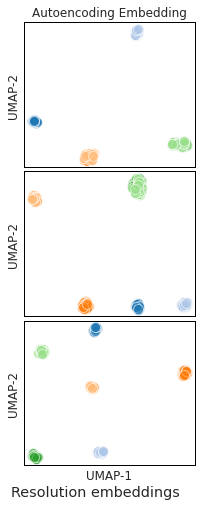

In [9]:
resolutions = [1,4,6]
sources = ["h_j"]

df_fig1 = df_emb[df_emb["resolution"].isin([f"{i}-resolution" for i in resolutions])]
df_fig1 = df_fig1[df_fig1["source"].isin(sources)]
# df_fig1 = df_fig1[df_fig1["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.FacetGrid(df_fig1, row="resolution", col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="Autoencoding Embedding", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label="UMAP-1", clear_inner=True, )
g.set_ylabels(label="UMAP-2", clear_inner=True, )
g.fig.supxlabel("Resolution embeddings")

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
# plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
plt.gcf().set_size_inches(3.5, 7)
        
plt.savefig("autoencoder_embeddings.png", dpi=500, format='png', transparent=True)